<a href="https://colab.research.google.com/github/CassandraCalciano/bert-recipe-classifier/blob/main/bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

In [1]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=43e17ba2713e0a4734a61614b6f0057e56aaff4f935e781516185e005a5ac973
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  3% |  1% |


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00


In [3]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df1 = pd.read_csv('/content/drive/MyDrive/ap_data/adjudicated.txt', sep = "\t", header=0, names=['id', 'adj', 'label', 'text'])
df2 = {'id': 2002430, 'adj': 'adjudicated', 'label': 'easy', 'text': '["Combine all ingredients in a food processor and blend until smooth.", "Enjoy!"]'}
data = df1.append(df2, ignore_index = True)

<ipython-input-5-b5627682baf4>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df1.append(df2, ignore_index = True)


In [6]:
# pre-process recipe text: stripping brackets, quotation marks (neccessary grammar)

clean = data['text'].str.replace('\[|\]|"', '')
data['text'] = clean

<ipython-input-6-2d9cd0da6986>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['text'].str.replace('\[|\]|"', '')


In [7]:
# adding the name of the dish as a feature

messy_ann = pd.read_csv('/content/drive/MyDrive/ap_data/cassie_ann.csv')
title = messy_ann['title']
data['recipe_name'] = title

In [8]:
# from the raw data set, adding back a column that ran Named Entity Recognition over the ingredients

messy_ann = messy_ann.rename({'general_ingredients': 'NER'}, axis=1)
data['NER'] = messy_ann['NER']

In [9]:
# Adding the proportion of periods to length of a recipe, this should account for short simple steps

text = data['text']
lengths = pd.Series([len(t) for t in text])
period_counts = pd.Series([t.count('.') for t in text])
period_len_prop = period_counts/lengths
data['prop_periods_len'] = period_len_prop * 100

In [10]:
# adding a one hot encoded col for hard and medium cooking methods

med_list = "saute|pan fry|steaming|shallow-fry|poach|steam|braise|roast|stove top|grill|pan-fry|BBQ|brown"
hard_list = "deep fry|caramelize|char"
def med_hard_binary(series):
    """
    Creates two binary series
    """
    med = []
    hard = []
    for string in series:
        if re.search(med_list, string):
            med.append(1)
        else:
            med.append(0)

        if re.search(hard_list, string):
            hard.append(1)
        else:
            hard.append(0)

    return pd.Series(med), pd.Series(hard)

In [11]:
# creating a binary column for the medium and easy cooking method
lower_text = data['text'].str.lower()
bin_med, bin_hard = med_hard_binary(lower_text)

In [12]:
data['medium_cooking_method'] = bin_med
data['hard_cooking_method'] = bin_hard

In [13]:
data['label'] = data['label'].replace({'easy': 0, 'medium': 1, 'hard': 2})

In [14]:
data

,id,adj,label,text,recipe_name,NER,prop_periods_len,medium_cooking_method,hard_cooking_method
0,699652,adjudicated,0,"Dissolve Jell-O in boiling water., Thaw frozen...",Hummus Bi Tahini,"[""garbanzo beans"", ""water"", ""tahini"", ""olive o...",2.356902,0,0
1,1133569,adjudicated,2,Soak the eggplant cubes in salt water in refri...,Strawberry Congealed Salad,"[""strawberry Jell-O"", ""boiling water"", ""pineap...",1.377410,1,0
2,710759,adjudicated,1,Heat butter over medium heat until delicate br...,Wyatt Cafeteria'S Baked Eggplant (Aubergine),"[""eggplant"", ""breadcrumbs"", ""milk"", ""milk"", ""b...",2.293578,1,0
3,2037928,adjudicated,0,take as many mini bagels as you want out and t...,Browned Butter Frosting,"[""butter"", ""vanilla"", ""powdered sugar"", ""milk""]",0.716846,0,0
4,2010166,adjudicated,2,"Combine the rhubarb, berries, 1/2 cup flour, a...",Sweet Savory Toasted peanut butter and jelly o...,"[""peanut butter"", ""preserves jelly"", ""bagles""]",1.049475,1,0
...,...,...,...,...,...,...,...,...,...
495,455450,adjudicated,0,"Same as Navy Bean Pottage, but delete cabbage ...",Lemon Buttermilk Chicken,"[""chicken breast fillet"", ""fresh breadcrumbs"",...",2.189781,0,0
496,145926,adjudicated,1,Marinate meat in Italian dressing in bag and l...,Mixed Vegetables,"[""butter"", ""fennel seed"", ""black cumin"", ""fenu...",2.068966,0,0
497,597061,adjudicated,0,Prepare brownies according to package directio...,"Bag-A-Deerwaterford, Michigan","[""loin"", ""Onion soup"", ""mushrooms"", ""Italian d...",1.886792,1,0
498,2071555,adjudicated,0,"Preheat oven to 350F., Mix all ingredients unt...",Cream Cheese Brownies,"[""brownie mix"", ""vanilla"", ""cream cheese"", ""bu...",2.976190,1,0


In [15]:
# splitting into 3 files: train.txt, dev.txt, and, test.txt with 300, 100, 100 labels respectively

train, test_and_dev = train_test_split(data, test_size=200, train_size=300, shuffle=True, random_state=42)
dev, test = train_test_split(test_and_dev, test_size=100, train_size=100, shuffle=True, random_state=42)

In [16]:
train.shape, test.shape, dev.shape

((300, 9), (100, 9), (100, 9))

In [17]:
train.to_csv("/content/drive/MyDrive/ap_data/splits/train.txt", sep="\t", index=False, header=False)
test.to_csv("/content/drive/MyDrive/ap_data/splits/test.txt", sep="\t", index=False, header=False)
dev.to_csv("/content/drive/MyDrive/ap_data/splits/dev.txt", sep="\t", index=False, header=False)

In [18]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data/splits"

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [20]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [21]:
def read_data(filename, labels, max_data_points=1000):

    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            text = cols[3]

            data.append(text)
            data_labels.append(labels[label])


    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)

    if max_data_points is None:
        return data, data_labels

    return data[:max_data_points], data_labels[:max_data_points]

In [22]:
labels=read_labels("%s/train.txt" % directory)

In [23]:
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)

In [24]:
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels, max_data_points=None)

In [25]:
test_x, test_y=read_data("%s/test.txt" % directory, labels, max_data_points=None)

In [26]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1
    return corr/total, total

In [27]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()

        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)

        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):

        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]

        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))

        return batches_x, batches_y


    def forward(self, batch_x): # can add things here, possibly more layers?

        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.

        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [28]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [29]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


In [30]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="google/bert_uncased_L-2_H-128_A-2"  #"bert-base-cased"
model_filename="mybert.model"
embedding_size=128  #768
doLowerCase=True

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Epoch 0, dev accuracy: 0.580
Epoch 1, dev accuracy: 0.580
Epoch 2, dev accuracy: 0.590
Epoch 3, dev accuracy: 0.590
Epoch 4, dev accuracy: 0.600
Epoch 5, dev accuracy: 0.610
Epoch 6, dev accuracy: 0.630
Epoch 7, dev accuracy: 0.670
Epoch 8, dev accuracy: 0.670
Epoch 9, dev accuracy: 0.690
Epoch 10, dev accuracy: 0.690
Epoch 11, dev accuracy: 0.720
Epoch 12, dev accuracy: 0.750
Epoch 13, dev accuracy: 0.750
Epoch 14, dev accuracy: 0.750
Epoch 15, dev accuracy: 0.760
Epoch 16, dev accuracy: 0.750
Epoch 17, dev accuracy: 0.720
Epoch 18, dev accuracy: 0.730
Epoch 19, dev accuracy: 0.740
Epoch 20, dev accuracy: 0.800
Epoch 21, dev accuracy: 0.800
Epoch 22, dev accuracy: 0.810
Epoch 23, dev accuracy: 0.800
Epoch 24, dev accuracy: 0.800
Epoch 25, dev accuracy: 0.790
Epoch 26, dev accuracy: 0.790
Epoch 27, dev accuracy: 0.780
Epoch 28, dev accuracy: 0.780
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.810


In [31]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.790, 95% CIs: [0.710 0.870]



In [32]:
def predict(model, x, y):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                all_preds.append(prediction)
    return all_preds

In [33]:
# get predictions for test batch
test_preds = predict(model, test_batch_x, test_batch_y)

In [34]:
# get test predictions into one list
y_preds = []
for i in np.arange(len(test_preds)):
    tensor = test_preds[i]
    y_preds.append(tensor.item())

In [35]:
og_y = test['label'].reset_index()
og_y = og_y.drop('index', axis=1)

In [36]:
test_df = pd.DataFrame({'y': og_y['label'], 'y_hat': pd.Series(y_preds)})

In [37]:
test_df

,y,y_hat
0,1,1
1,0,1
2,0,1
3,0,2
4,1,0
...,...,...
95,1,1
96,2,2
97,1,0
98,1,1


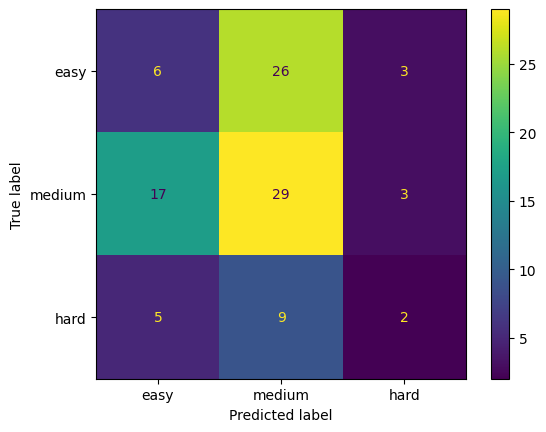

In [38]:
cm = confusion_matrix(test_df['y'], test_df['y_hat'], labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['easy', 'medium', 'hard'])
disp.plot()
plt.show()

##Part b: Analysis

###Break Down of Features and How they Helped

1. There were a lot of brackets ([]) and quotation marks in our raw data. We did not want these considered or accidently picked up by our model as a feature for easy, medium, recipes. Therefore, we pre-processed the recipes by taking out the brackets and quotations that came from the raw data. Honestly, this slightly hurt our accuracy going from about 0.75 to 0.7 in our upper confidence bound. It is likely the model was picking up on the frequency of these grammar marks as an indicator of recipe difficulty. Even though this hurt our accuracy we still wanted to take out this unnecessary information that did not have to do with the actual text of our recipes.


2. Included in our raw dataset, but not in our adjudicated dataset was the title for each recipe. We added the title of the recipe as a feature because we believed the title should be considered part of the recipe. Some titles were very informative like, Roasted Duck Breast, while others were goofier like, Mi Mama’s Famous Mud Pie. This also provides information with the more informative titles being harder recipes and the goofier recipes mostly falling in the easy or medium category. This improved the accuracy a little bit.


3. To encapsulate the short, often easy steps, we added a feature for the proportion of periods to the length of a recipe. Recipes that have very short steps, likely have many easy steps, corresponding to a level of easy or medium. An easier recipe should have a higher proportion of periods to the length of the recipe.


4. Our raw dataset included a column for Named Entity Recognition. Ran over the recipes, named entity recognition found all raw ingredients in our recipes. This did not include measurements. We added this shortened list of entities as a feature to include. This greatly improved our accuracy from about 0.76 to the upper bound of 0.82. This is likely because ingredients like sugar, regardless of how much, are associated with easier recipes and ingredients like steak are associated with harder recipes. Picking out these entities allowed the bert model to weigh the ingredients outside of however they were used in a cooking method. While we did have a category in our annotation guidelines about labeling certain ingredients as hard, especially milk and cream, which burn easily when cooked, we largely did not include a lot about ingredients in our guidelines. Pairing ingredients with cooking methods and indicating what difficulty category to be in would be a great thing to add to our annotation guidelines.


5. To emphasize the cooking method category in our annotation guidelines we created two columns that equal a 1 if a recipe contains a medium cooking method, with a 0 otherwise, and a 1 if a recipe contains a hard cooking method, with a 0 otherwise. When annotating our recipes the cooking method stood out to us as a very important indicator of difficulty. We did not choose to include a binary column for easy cooking methods because all recipes contain easy cooking methods and this would be redundant. This improved our accuracy by 2-3%, which surprised us at first. However, these binary columns did not take into account how often these cooking methods were used throughout the recipe, which explains why they did not help the accuracy by that much.


###Analysis of Results

Medium is the most prevalent label in our 'Adjudicated' dataset. This uneven balance of data likely caused the errors in labeling between easy and medium labels. This may also cause the model to have difficulty differentiating between easy vs. medium, or medium vs. hard recipes, due to there being not very many examples of easy and hard recipes. One solution to this would be to take a more representative sample of recipes so that we get a more even mix of easy, medium, hard. To get 500 recipes we randomly sampled from a dataset about about 10,000 recipes. Taking multiple samples and seeing the distribution of the entire dataset compared to a sample of 500 would help us fix this issue of oversampling from a medium. Instead of using more data points, one solution is to fix the class weights. We could weight easy and hard recipes higher than medium recipes We could also add more labels, to split up medium-level recipes further, thereby creating a more even distribution of labels.

Additionally, all hard level recipes were classified incorrectly, with seven out of the sixteen hard recipes labeled as easy and nine labeled as medium. Our model systematically makes the mistakes of ignoring hard cooking methods that would take a recipe from medium to hard. Our model also systematically labels recipes with easy preparation steps, even though the whole recipe is medium.

Our model only works for recipes that are in English. Additionally, it is more generally catered towards American and Western audiences, as most of the recipes in the dataset were American or Western recipes. Based on the low diversity of recipes in our dataset, the accuracy of our model would absolutely decrease if we tested it on more diverse recipes, that is, recipes not considered American or Western. To give an example, our dataset does not have actions common in more ethnic recipes such as 'grating' listed under medium or hard which would typically be considered in real life. So, our model would automatically list it as 'easy' which could be considered a bias against ethnic recipes.

Fundamentally, it seems that the difficulty of a recipe is quite difficult to determine based on text alone, especially with only three broad categories (easy, medium, hard) since most predictions skew towards medium. This is reasonable because most recipes really do fall into a medium category in real life and all of us in our group consider ourselves a medium level chef. Not only that, but there was a great amount of variance when making distinctions between easy and medium, which means that our boundaries have not been clearly drawn.We can combat this by adding more features that reflect our guidelines, such as boundary tie-breaking factors, such as things that immediately make a recipe hard (i.e. melting chocolate). In another iteration of this project, we could combat this by creating clearer boundary lines in our guidelines. This model is not particularly useful at the moment, but could be very useful in practice once boundaries are clearly established. We suspect that the model also does not perform very well due to discrepancies in the initial annotation. Our group struggled with many disagreements during the initial annotations, which reflects the confusion around the boundaries for even human annotators. This reflects inconsistency in labeling. Trained on these human annotations, it is expected that the model would also have difficulty differentiating between labels.


